<a href="https://colab.research.google.com/github/juliorodrigues07/datachallenge/blob/master/notebook/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio do Processo Seletivo Para a Vaga de Estágio em Data Analytics na Frexco - 2023

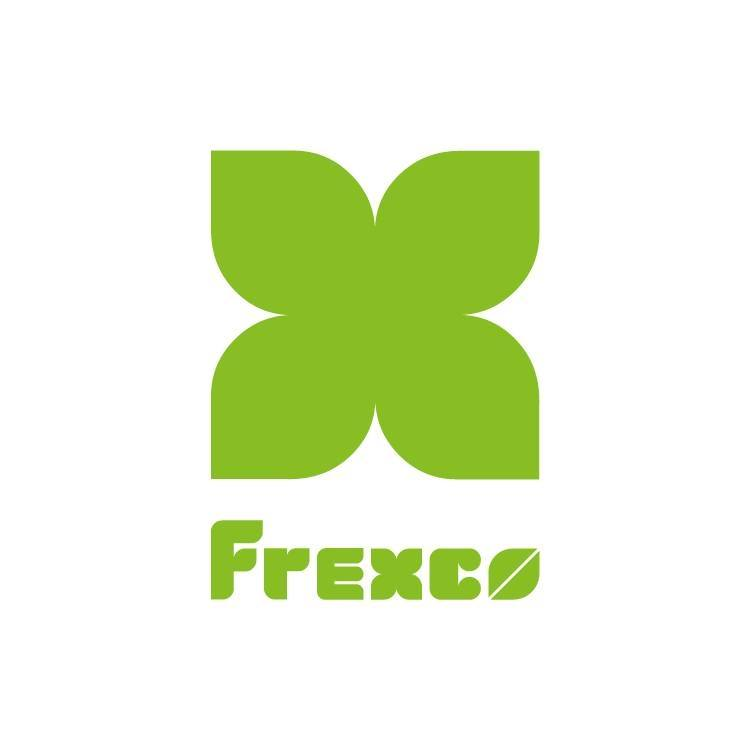






- Este problema basicamente se resume a realização de previsões, dado um conjunto de dados observados durante determinado período de tempo. Nosso interesse aqui é inicialmente trabalhar apenas com uma variável, utilizando-a para prever a mesma (classe e atributo ao mesmo tempo). Isto é, dada a distribuição das vendas ao longo de apenas 46 dias, devemos formular um modelo para prever as vendas nos próximos 5 dias. De posse destas informações, já temos capacidade para fazer uma análise inicial sobre qual tipo de modelagem se adequaria melhor para o problema, este que indica claramente um caso de modelagem por séries temporais. Devemos analisar a linha do tempo dos dados como um todo, buscando possíveis informações como padrões, tendências (aumento, declínio, constância), sazonalidade (possíveis padrões de comportamento ao longo do tempo), estacionariedade (independência ou não dos valores da série em relação ao tempo), entre outros. A partir disto, possivelmente poderemos obter base suficiente para formular um modelo de previsão com precisão minimamente aceitável, provendo resultados satisfatórios conforme as necessidades exigidas.



# **1.   Importação das Bibliotecas Necessárias**



In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.multioutput import MultiOutputRegressor
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import warnings
import locale
import os



## **1.1. Definindo alguns parâmetros globais para facilitar a visualização dos dados**



In [ ]:
warnings.filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Para exibir dias da semana em português-BR nos gráficos (consegui utilizar somente localmente)
# locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')



# **2.   Carregamento da Base de Dados**



In [ ]:
frexco_dataset = pd.read_excel(os.getcwd() + '/Dados.xlsx', usecols=['Data', 'Vendas'])

print(frexco_dataset.head())
print(frexco_dataset.tail())

# Verificando se há valores ausentes
print(frexco_dataset.isna().sum())

        Data  Vendas
0 2022-12-06     870
1 2022-12-07     868
2 2022-12-08    1189
3 2022-12-09     742
4 2022-12-10     317
         Data  Vendas
41 2023-01-16    1692
42 2023-01-17    1097
43 2023-01-18    1302
44 2023-01-19    1405
45 2023-01-20     945
Data      0
Vendas    0
dtype: int64


In [ ]:
sales = frexco_dataset.drop('Data', axis='columns')
dates = frexco_dataset['Data'].apply(lambda x: x.strftime('%d-%m-%Y'))

print(sales.head())
print(dates.head())

   Vendas
0     870
1     868
2    1189
3     742
4     317
0    06-12-2022
1    07-12-2022
2    08-12-2022
3    09-12-2022
4    10-12-2022
Name: Data, dtype: object




# **3.   Análise e Visualização dos Dados**

- O desvio padrão apresenta-se relativamente elevado, indicando uma possível grande dispersão no conjunto de dados observado.



In [ ]:
# Resumos estatísticos (média, mínimo, máximo, desvio padrão, quartis, ...)
print(sales.describe().transpose())

        count        mean         std   min    25%    50%      75%     max
Vendas   46.0  755.434783  430.762201  18.0  346.5  810.5  1053.75  1692.0




## **3.1.   Série Temporal Completa**

- Linha do tempo ilustrando a demanda diária ao longo dos 46 dias utilizando um gráfico de linhas.
- Já é possível identificar aspectos iniciais como a sazonalidade, com o gráfico sempre apresentando vales a cada 7 dias (fins de semana).
- A série também apresenta-se inicialmente como não estacionária. Grande parte dos modelos de previsão (regressores) são formulados para trabalhar com séries estacionárias. Estas não possuem dependências de efeitos sazonais, o que pode tornar as previsões mais confiáveis.



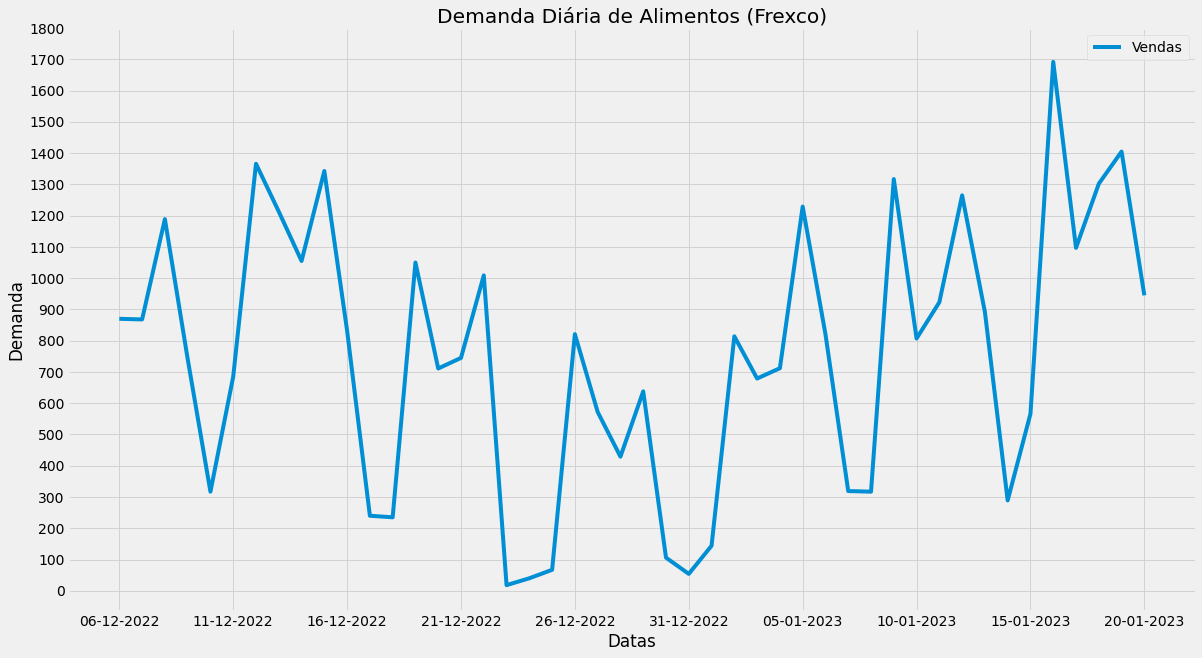

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(dates, sales)

ax.set_title('Demanda Diária de Alimentos (Frexco)')
ax.set_xlabel('Datas')
ax.set_ylabel('Demanda')

# Controle dos saltos nos intervalos do gráfico
major_ticks = np.arange(0, 1801, 100)
minor_ticks = np.arange(0, 47, 5)

ax.set_xticks(minor_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set_yticks(major_ticks)
ax.set_yticks(major_ticks, minor=True)

ax.grid(which='both')
ax.grid(which='minor', alpha=0.8)
ax.grid(which='major', alpha=0.8)
ax.legend(['Vendas'], loc='upper right')

plt.show()
# TODO: Barplot para a série temporal?




## **3.2.   Série Temporal Semanal**

- Gráfico de linha apresentando a discrepância na demanda em um fim de semana em relação ao restante dos dias.

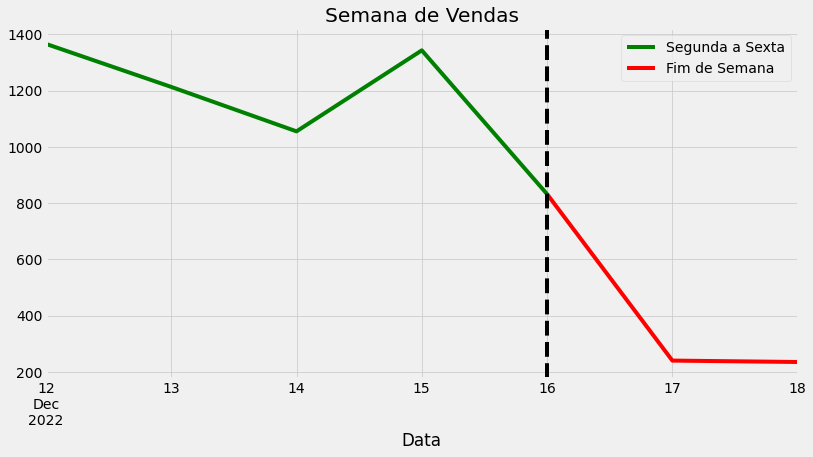

In [ ]:
dataset = frexco_dataset.copy()

dataset['Data'] = pd.to_datetime(dataset['Data'], infer_datetime_format=True)
dataset = dataset.set_index('Data')

# Separa os dados observados no fim de semana (12/12/2021 a 18/12/2022, 17 e 18 -> sábado e domingo)
week = dataset.loc[(dataset.index >= '2022-12-12') & (dataset.index <= '2022-12-16')]
weekend = dataset.loc[(dataset.index >= '2022-12-16') & (dataset.index <= '2022-12-18')]

fig, ax = plt.subplots(figsize=(12, 6))

week.plot(ax=ax, label='Segunda a Sexta', title='Semana de Vendas', color='green')
weekend.plot(ax=ax, label='Fim de Semana', color='red')

ax.axvline('2022-12-16', color='black', ls='--')
ax.legend(['Segunda a Sexta', 'Fim de Semana'], loc='best')

ax.grid(which='both')
ax.grid(which='minor', alpha=0.8)
ax.grid(which='major', alpha=0.8)
plt.show()



## **3.3.   Boxplot para Análise do Histórico da Demanda Conforme o Dia da Semana**

- Ilustração gráfica completa sobre a distribuição da demanda ao longo do período de 46 dias, apresentando os quartis, médias, máximos e mínimos para cada dia da semana.
- Agora está mais que evidente que a demanda nos dias que correspondem ao fim de semana (sábado e domingo) é bastante inferior à apresentada no restante dos dias.
- A sazonalidade semanal se sobressaiu.


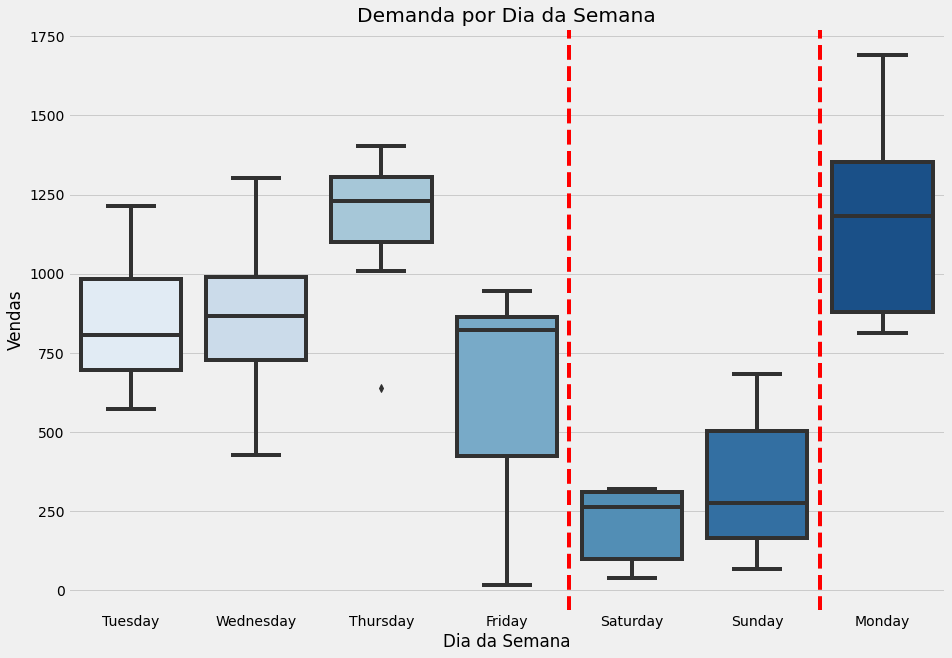

In [ ]:
dataset = frexco_dataset.copy()

dataset['Dia da Semana'] = dataset['Data'].dt.day_name()
dataset = dataset.set_index('Data')
dataset.index = pd.to_datetime(dataset.index)

fig, ax = plt.subplots(figsize=(14, 10))
sns.boxplot(data=dataset, x='Dia da Semana', y='Vendas', palette='Blues')

ax.axvline(x=3.5, color='red', ls='--')
ax.axvline(x=5.5, color='red', ls='--')
ax.set_title('Demanda por Dia da Semana')

plt.show()



## **3.4.   Decomposição da Série Temporal**

- Um resumo gráfico da série temporal, apresentando tendência, sazonalidade, resíduos, "nível de estacionariedade", distribuição dos dados, entre outros aspectos.

---





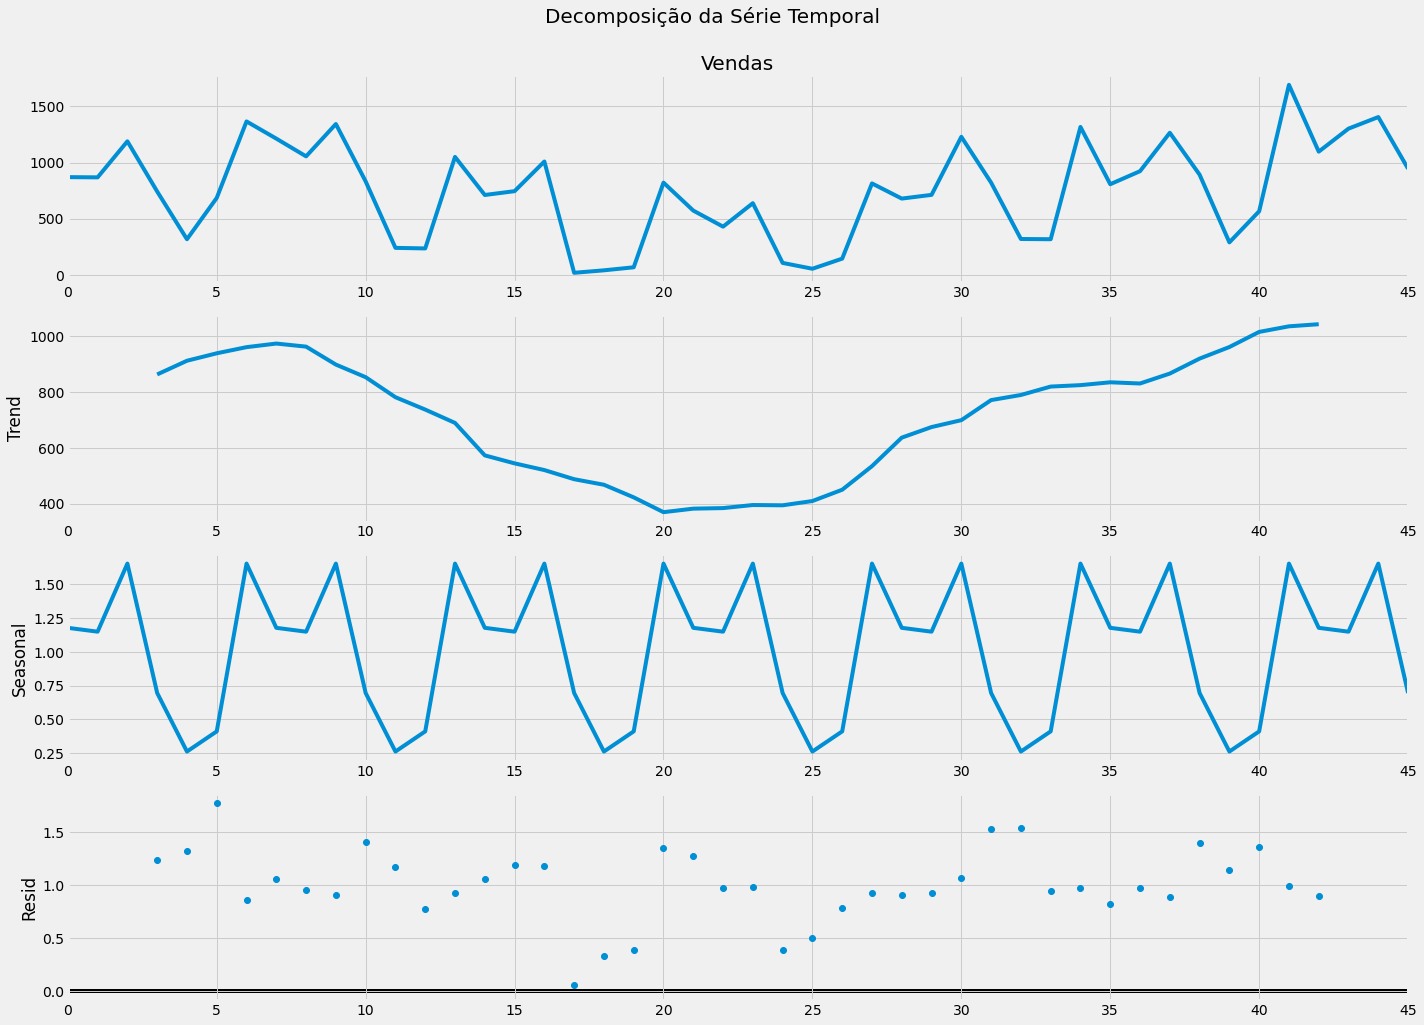

In [ ]:
dataset = frexco_dataset.copy()

multiplicative_decomposition = seasonal_decompose(dataset['Vendas'], model='multiplicative', period=7)

plt.rcParams.update({'figure.figsize': (20, 15)})
multiplicative_decomposition.plot().suptitle('Decomposição da Série Temporal', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()



## **3.5.   Diferenciação na Série Temporal**

- Uma tentativa de aplicar transformações na série temporal, aplicando diferenciação com o intuito de torná-la estacionária, o que possivelmente tornaria a aplicação do modelo ainda a ser escolhido e os respectivos resultados obtidos mais confiáveis. 





### **3.5.1.   Teste de Estacionariedade**



In [ ]:
def stationary_test(data):

    result = adfuller(data)
    p_value = result[1]
    n_lags = result[2]
    print(f'p-value: {p_value}, lags: {n_lags}')

    if p_value <= 0.05:
        print('Rejeita H0, série estacionária!\n')
    else:
        print("Não rejeita H0 (hipótese fraca), o que indica que a série não está estacionária!\n")

data = sales.copy()

first_diff = data.diff()
stationary_test(data.dropna())

second_diff = first_diff.diff()
stationary_test(second_diff.dropna())

p-value: 0.5297447855798445, lags: 7
Não rejeita H0 (hipótese fraca), o que indica que a série não está estacionária!

p-value: 4.496230722965386e-08, lags: 6
Rejeita H0, série estacionária!



### **3.5.2.   Visualização em Gráfico**


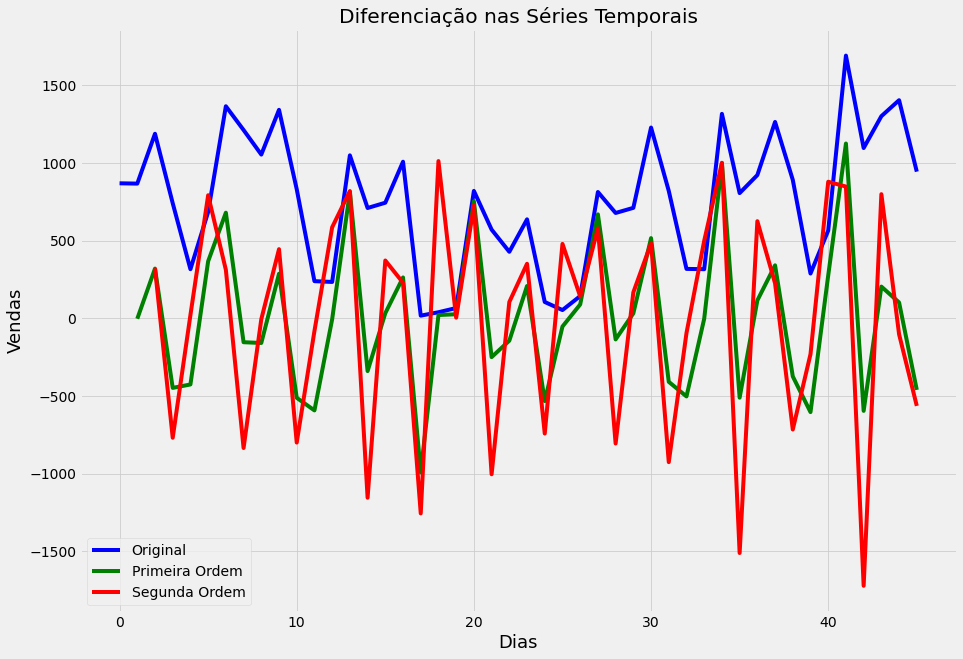

In [ ]:
data = sales.copy()

fig, ax = plt.subplots(figsize=(14, 10))

data.plot(ax=ax, label='Original', color='blue')
first_diff.plot(ax=ax, label='Primeira Ordem', color='green')
second_diff.plot(ax=ax, label='Segunda Ordem', color='red')

ax.set_title('Diferenciação nas Séries Temporais')
ax.set_ylabel("Vendas", fontsize=18)
ax.set_xlabel("Dias", fontsize=18)

ax.grid(which='minor')
ax.grid(which='minor', alpha=0.8)
ax.grid(which='major', alpha=0.8)

plt.legend(['Original', 'Primeira Ordem', 'Segunda Ordem'], loc='lower left')
plt.show()



## **3.6.   Autocorrelação e Autocorrelação Parcial da Série Temporal**

- Mais uma ferramenta para análise dos dados, os gráficos de autocorrelação e autocorrelação parcial nos apresentarão a significância dos *lags*, ou seja, o quanto valores antecessores na série podem ser úteis na previsão dos sucessores.

- Além disto, também podemos e devemos utilizar tais ferramentas para analisar aspectos já mencionados anteriormente, como a estacionariedade, aleatoriedade, tendências, sazonalidade, entre outros.

- O gráfico de autocorrelação parcial pode se mostrar bastante útil no momento de decisão para especificar um modelo de regressão ou autoregressivo. 

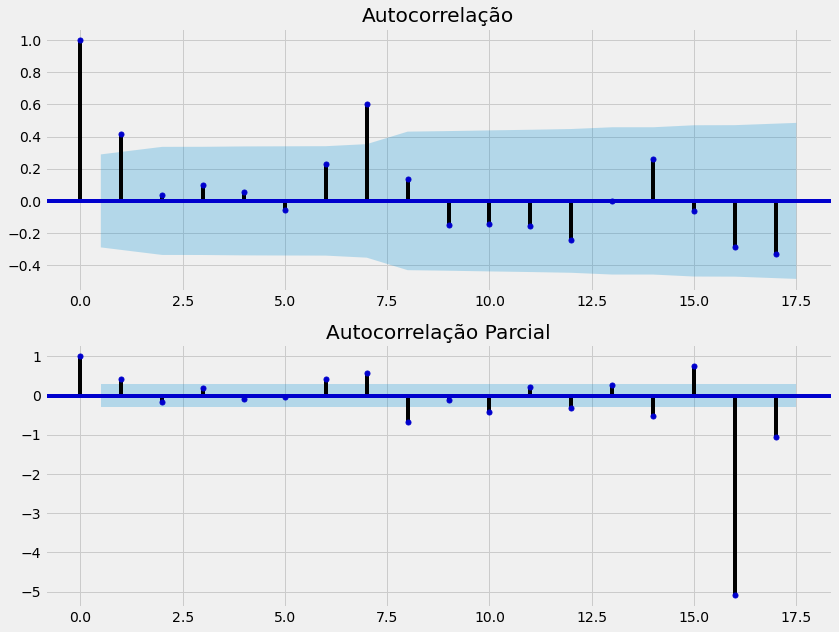

In [ ]:
data = sales.copy()

fig = plt.figure(figsize=(12, 9))

ax1 = fig.add_subplot(211)
fig = plot_acf(data, title='Autocorrelação', ax=ax1, color='mediumblue')

ax2 = fig.add_subplot(212)
fig = plot_pacf(data, title='Autocorrelação Parcial', ax=ax2, color='mediumblue')

plt.tight_layout()
plt.show()



# 4.   **Modelos de Aprendizado de Máquina para Séries Temporais**

- Nesta seção, serão explanados brevemente os modelos formulados para a realização das previsões, resultados obtidos, e a escolha final como solução do problema.

- Já me adiantando, houveram modelos em que achei interessante utilizar uma característica nova no lugar da existente (*Vendas*). Isto é, devido a sazonalidade observada na distribuição dos dados, formulei alguns modelos utilizando como "entrada" de previsão o dia da semana.

- Alguns modelos de *machine learning* não são capazes de operar com atributos categóricos, o que é exatamente o caso, já que estamos tentando realizar previsões de vendas para os 5 dias da semana após 20/01/2023 (sáb, dom, seg, ter, qua).

- Por isto, apliquei uma etapa de criação da nova característica e também de pré-processamento para adequá-la a entrada do modelo, transformando estes valores nominais em valores inteiros.

- **Exemplo**: Uma característica que pode assumir os valores: {'ruim', 'mediano', 'bom'}, poderia ser codificada como: {0, 1, 2}, após a etapa de pré-processamento. 

In [ ]:
def pre_processing(data):

    encoding = preprocessing.LabelEncoder()

    # Dicretiza atributos categóricos ('segunda', 'terça', 'quarta', ...) -> (0, 1, 2, ...)
    encoding.fit(data['Dia da Semana'])
    data['Dia da Semana'] = encoding.transform(data['Dia da Semana'].copy())

    return data

def print_result(predictions):

    begin = '2023-01-21'
    end = '2023-01-25'
    period = pd.date_range(begin, end).tolist()
    result = pd.DataFrame(period, columns=['Data'])

    # Exibição dos resultados das previsões
    result['Vendas'] = np.around(predictions[:5]).astype(int)
    print(result)
    print(f"Total:\t\t {sum(result['Vendas'])}")

    return result



## **4.1.   Regressão Linear Simples**

- Talvez um dos modelos mais clássicos da literatura na área de aprendizado de máquina, e que pode ser utilizado para séries temporais, este foi o ponto de partida na formulação dos modelos de previsão.

- Sua previsão não leva em conta a característica citada anteriormente (dia da semana), o que somado a sua complexidade excessivamente baixa, inadequação para base de dados pequenas e tendências incertas, produziu resultados bastante enviesados, bem próximos a média geral e com desvio padrão quase nulo entre si, o que o torna não confiável, e consequentemente, descartável na formulação da solução.

In [ ]:
data = sales.copy()
size = len(data)

lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(np.arange(size).reshape(-1, 1), data)

predictions = lr_model.predict(np.arange(size + 1, size + 6).reshape(-1, 1))

lr_final = np.around(predictions).astype(int)
print_result(lr_final)

print(f'\nRMSE: {np.sqrt(mean_squared_error(np.arange(size).reshape(-1, 1), data))}')

        Data  Vendas
0 2023-01-21     858
1 2023-01-22     862
2 2023-01-23     866
3 2023-01-24     871
4 2023-01-25     875
Total:		 4332

RMSE: 847.0038627292445




## **4.2.   XGBoost (Extreme Gradient Boosting)**

- Um algoritmo *ensemble* (comitê de classificação) que une os já consolidados modelos de aprendizado de máquina: árvore de decisão e *gradient boosting*.

- Como o próprio nome sugere, este utiliza a técnica de *boosting* na modelagem com o intuito de reduzir viés, e possui uma quantidade bastante diversificada de hiperparâmetros para ajustes finos conforme cada situação.

- Nativamente, o *XGBoost* não suporta previsões múltiplas (apenas uma por vez). Por isto, foi utilizado um recurso da biblioteca *scikit-learn* que possibilita previsões múltiplas para regressores (*MultiOutputRegressor*).

- Para o treinamento deste modelo, foi utilizada como característica de entrada apenas aquela citada anteriormente, o dia da semana.

- Após vários ajustes nos hiperparâmetros, os resultados obtidos foram completamente distintos dos provenientes da regressão linear, e muito mais aceitáveis.

- O algoritmo conseguiu captar a sazonalidade presente nos dados, apresentando previsões baixas para o fim de semana em relação ao restante dos dias, embora a tendência das mesmas apresente queda em relação as semanas anteriores. De qualquer forma, por enquanto este é um modelo a ser considerado como possível candidato à solução.



In [ ]:
data = frexco_dataset.copy()

test = data.drop(['Data'], axis='columns')

data['Dia da Semana'] = data['Data'].dt.day_name()

train = data.drop(['Data', 'Vendas'], axis='columns')
train = pre_processing(train.copy())

xgb_regressor = xgb.XGBRegressor(base_score=0.5,
                                  booster='gbtree',
                                  n_estimators=250,
                                  n_jobs=-1,
                                  objective='reg:squarederror',
                                  max_depth=5,
                                  learning_rate=0.03)

# Período para previsão (Deve conter os 7 dias para a codificação dos dias da semana coincidirem)
begin = '2023-01-21'
end = '2023-01-27'
period = pd.date_range(begin, end).tolist()

# Cria uma base de dados contendo as datas para previsão
new_data = pd.DataFrame(period, columns=['Data'])
new_data['Dia da Semana'] = new_data['Data'].dt.day_name()
new_data = new_data.drop(['Data'], axis='columns')
new_data = pre_processing(new_data.copy())

multi_xgb_model = MultiOutputRegressor(xgb_regressor, n_jobs=-1).fit(train, test)
predictions = multi_xgb_model.predict(new_data)

# print()
xgb_final = np.around(predictions[:5]).astype(int)
print_result(xgb_final)

print(f'\nRMSE: {np.sqrt(mean_squared_error(train, test))}')

        Data  Vendas
0 2023-01-21     210
1 2023-01-22     335
2 2023-01-23    1175
3 2023-01-24     849
4 2023-01-25     861
Total:		 3430

RMSE: 864.4455750213041




## **4.3.   ARIMA**

- Método muito utilizado para previsões com séries temporais, este geralmente assume que as séries são estacionárias e não possuem sazonalidade, o que pode causar impactos bastante negativos no resultado final.

- O bom aproveitamento do modelo depende de um série estacionária, o que já observamos que não é o caso. Entretando, pode ser considerado um dos melhores métodos em previsões futuras se bem utilizado, e não deve ser ignorado na construção desta solução.

- Entretanto, nossa série temporal não sofreu as transformações adequadas para aplicação correta deste método, o que implicou em um resultado nada satisfatório novamente, similar à aquele apresentado pela regressão linear.

- Seus hiperparâmetros também não são triviais de se refinar, e exigem um estudo mais aprofundado tanto do modelo, quanto da base de dados para adequação.



In [ ]:
data = frexco_dataset.copy()

train = data.drop(['Data'], axis='columns')

arima_regressor = ARIMA(train, order=(1, 2, 1))
arima_model = arima_regressor.fit()
arima_predictions = arima_model.forecast(steps=5)

print_result(arima_predictions.tolist())
print(f'\nRMSE: {np.sqrt(pow(arima_model.resid, 2).mean())}')

        Data  Vendas
0 2023-01-21    1029
1 2023-01-22    1022
2 2023-01-23    1030
3 2023-01-24    1036
4 2023-01-25    1042
Total:		 5159

RMSE: 489.55535259070217




## **4.4.   SARIMAX**

- Assim como o ARIMA (pertencente à mesma família de regressores), é considerado um dos melhores métodos para trabalhar com previsões futuras em séries temporais.

- Entretanto, neste caso não existe restrição quanto à possível sazonalidade presente na série temporal, o que o torna um bom candidato na formulação do modelo solução.

- Novamente, os parâmetros são ainda mais complexos de se refinar, mas mesmo assim, o resultado obtido foi surpreendente.

- O modelo foi capaz de captar e aplicar a sazonalidade nas predições utilizando os dados referentes as demandas observadas no período de 46 dias.

- No entanto, em contraste com o que aconteceu na aplicação do XGBoost, a tendência nas previsões obtidas não aparenta anomalias à primeira vista.

- A raiz do erro quadrático médio (RMSE - métrica popular na literatura para avaliação de modelos) também foi a menor observada entre os quatro modelos.


In [ ]:
data = frexco_dataset.copy()

train = data.drop(['Data'], axis='columns')

sarimax_regressor = SARIMAX(train, order=(1, 1, 0), seasonal_order=(1, 1, 0, 7))
sarimax_model = sarimax_regressor.fit(disp=False)
sarimax_predictions = sarimax_model.forecast(steps=5)

print_result(sarimax_predictions.tolist())
print(f'\nRMSE: {np.sqrt(pow(sarimax_model.resid, 2).mean())}')

# TODO: Refinar hiperparâmetros dos regressores ARIMA
# TODO: Analisar ferramenta para selecionar de forma automática qual seria o modelo mais adequado para este caso (auto_arima, pycaret, ...?)

        Data  Vendas
0 2023-01-21     387
1 2023-01-22     596
2 2023-01-23    1696
3 2023-01-24    1119
4 2023-01-25    1304
Total:		 5102

RMSE: 294.16612788394696




## **4.5.   Avaliação dos Modelos**

- Gráfico de linha sumarizando as previsões realizadas por cada um dos modelos na série temporal.

- SARIMAX e XGBoost se mostram promissores, enquanto ARIMA e regressão linear apresentaram resultados inesperados e insatisfatórios.

- No gráfico de linha de treinamento do modelo SARIMAX, podemos observar uma adequação bastante satisfatória à distruibuição dos dados nas previsões.



        Data  Vendas
0 2023-01-21     858
1 2023-01-22     862
2 2023-01-23     866
3 2023-01-24     871
4 2023-01-25     875
Total:		 4332
        Data  Vendas
0 2023-01-21     210
1 2023-01-22     335
2 2023-01-23    1175
3 2023-01-24     849
4 2023-01-25     861
Total:		 3430
        Data  Vendas
0 2023-01-21    1029
1 2023-01-22    1022
2 2023-01-23    1030
3 2023-01-24    1036
4 2023-01-25    1042
Total:		 5159
        Data  Vendas
0 2023-01-21     387
1 2023-01-22     596
2 2023-01-23    1696
3 2023-01-24    1119
4 2023-01-25    1304
Total:		 5102


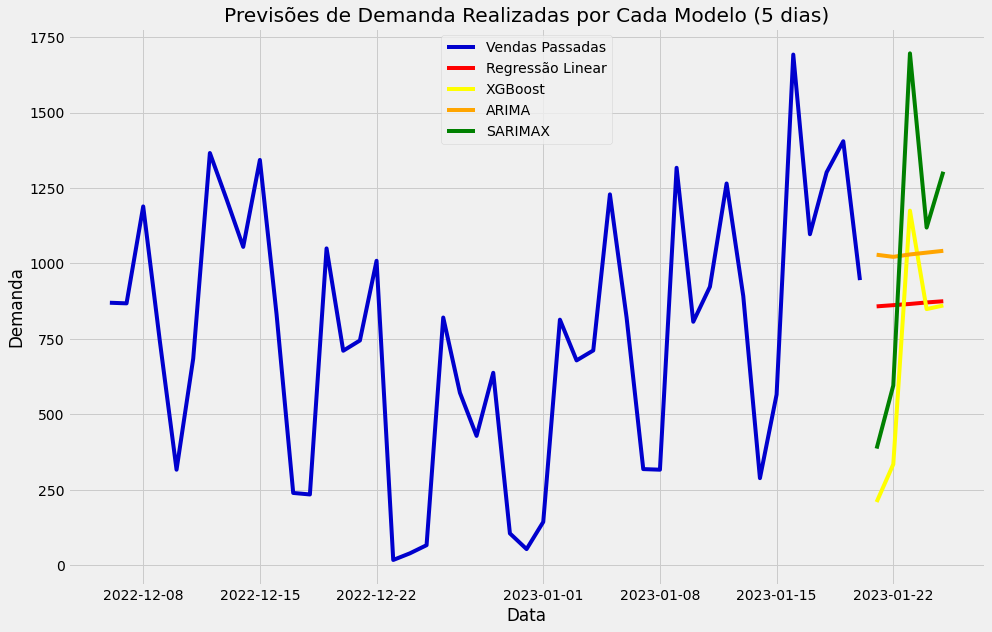

In [ ]:
data = frexco_dataset.copy()

a = pd.DataFrame(print_result(lr_final))
b = pd.DataFrame(print_result(xgb_final))
c = pd.DataFrame(print_result(arima_predictions.tolist()))
d = pd.DataFrame(print_result(sarimax_predictions.tolist()))

plt.figure(figsize=(14, 9))
plt.plot(data['Data'], data['Vendas'], label='Vendas Passadas', color='mediumblue')
plt.plot(a['Data'], a['Vendas'], label='Regressão Linear', color='red')
plt.plot(b['Data'], b['Vendas'], label='XGBoost', color='yellow')
plt.plot(c['Data'], c['Vendas'], label='ARIMA', color='orange')
plt.plot(d['Data'], d['Vendas'], label='SARIMAX', color='green')

plt.title('Previsões de Demanda Realizadas por Cada Modelo (5 dias)')
plt.xlabel('Data')
plt.ylabel('Demanda')

plt.legend(['Vendas Passadas', 'Regressão Linear', 'XGBoost', 'ARIMA', 'SARIMAX'], loc='upper center')
plt.grid('both')
plt.tight_layout()
plt.show()

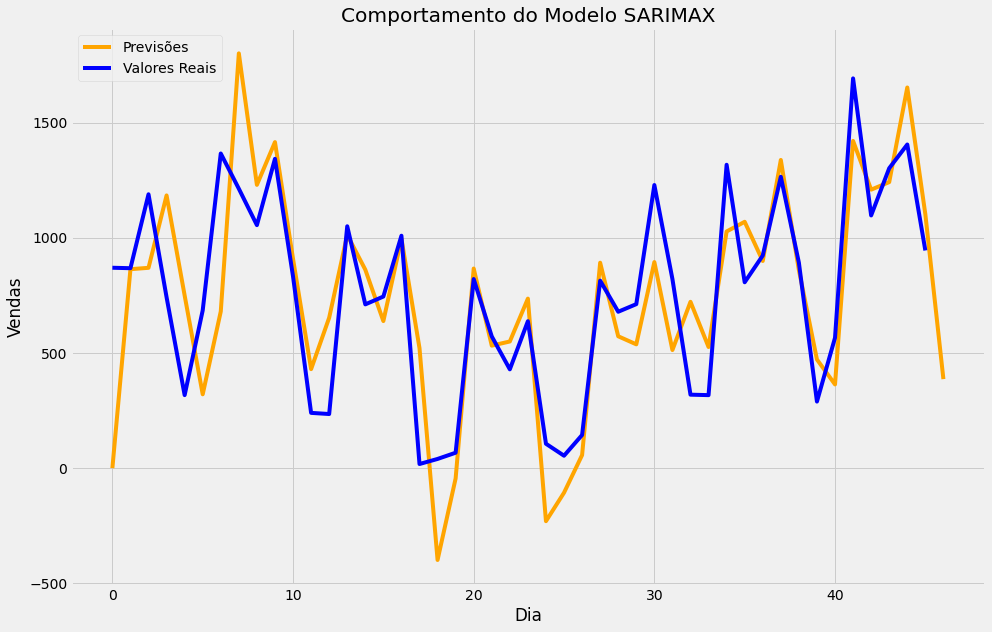

In [ ]:
data = frexco_dataset.copy()

predictions = sarimax_model.predict(start=0, end=46)

plt.figure(figsize=(14, 9))

plt.plot(predictions, label='Previsões', color='orange')
plt.plot(data['Vendas'], label='Valores Reais', color='blue')

plt.title("Comportamento do Modelo SARIMAX")
plt.xlabel('Dia')
plt.ylabel('Vendas')

plt.legend(['Previsões', 'Valores Reais'])
plt.grid('both')
plt.tight_layout()
plt.show()

# TODO: Comparar o aprendizado dos modelos em gráfico, assim como as métricas de erro (RMSE)



## **4.6.   Solução Final**

- O modelo selecionado como solução final foi o SARIMAX.
- Apresentou o menor RMSE, e mesmo sem refinamento dos hiperparâmetros, apresentou resultados interessantes, com bom ajuste aos valores reais no treinamento e previsões futuras satisfatórias.

- 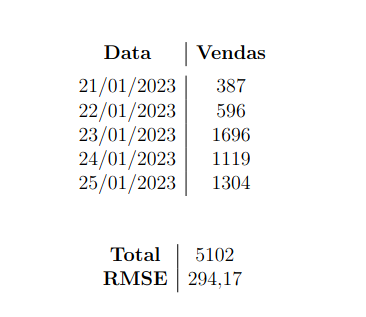



# **5.   Considerações Finais**

- Mesmo sendo um exemplo didático, existem possibilidades para explorar de forma mais profunda e aproveitar ao máximo estes dados.
- Como trabalhos futuros, além de refinar os hiperparâmetros dos modelos já utilizados, há também a opção de explorar outros modelos que podem se mostrar interessantes.
- Além disto, pode ser realizada uma análise mais profunda quanto aos aspectos da base de dados e pré-processamento. Por exemplo, a série temporal apresentou uma leve tendência de declínio para então crescer novamente ao longo de todo o período.
- Caso esta tendência também se encaixe como uma sazonalidade (no caso de 46 dias), a série deveria apresentar ligeiro declínio nas próximas semanas, fazendo com que neste caso, o XGBoost se adeque melhor à mesma, já que os valores brutos de vendas previstos pelo mesmo foram inferiores aos da última semana observada. Com um quantidade maior de dados, o gráfico de linha da série temporal poderia se assemelhar à uma senoide, apresentando vales e picos significativos a cada 46 dias.
- Outra possibilidade, seria de que este declínio recente foi consequência apenas dos feriados de fim de ano, e que agora as vendas devem começar a crescer novamente. Neste caso, o modelo SARIMAX escolhido previamente se ajustaria melhor à série.
- Com um conjunto maior de dados, existe a possibilidade de aplicar *feature engineering*, criando uma característica para indicar feriados por exemplo, estes que por sua vez, podem implicar em grande impacto em previsões futuras.



